# Purpose of this simulation


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

# ideas

In [2]:

#for comparision
# exp_conds = ['wo_feature_selection', 
#              'w_iter_feature_selection',
#             'start_with_high_SNR_neurons']

# for e in exp_conds: print(e)


In [3]:
#for comparision

exp_conds = ['wo_FS_0.7', 'iter_0.7', 'same_0.7']



for e in exp_conds: print(e)

wo_FS_0.7
iter_0.7
same_0.7


In [4]:
neuron_types = ['noisy', 'non_noisy']



n_neurons = 32

n_neurons_noisy_group = 24

n_neurons_no_noise_group = 8





no_noise_neuron_ind = np.arange(n_neurons_no_noise_group)

noise_neuron_ind = np.arange(n_neurons_no_noise_group, n_neurons_noisy_group + n_neurons_no_noise_group)



neuron_type_indices_in_a_list = [

    noise_neuron_ind, 

    no_noise_neuron_ind

]





noise_neuron_list = np.full(n_neurons, False, dtype = bool)

no_noise_neuron_list = np.full(n_neurons, False, dtype = bool)





noise_neuron_list[noise_neuron_ind] = True

no_noise_neuron_list[no_noise_neuron_ind] = True







neuron_type_bool_list = [

    noise_neuron_list,

    no_noise_neuron_list,

]



N_TYPES_OF_NEURONS = 2



print('We have two types of indices: ')

for t,l in enumerate(neuron_type_indices_in_a_list): print(f'{neuron_types[t]}:{l}')

We have two types of indices: 
noisy:[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
non_noisy:[0 1 2 3 4 5 6 7]


# Preproc the feature files

In [5]:
import aopy
import tables
import os

def load_feature_selection_files(data_dump_folder, exp_conds):
    """
    load feature selection from data dump folder
    
    Args;
    
    Returns:
        exp_data_all: a list of exp_data as parsed by bmi3d
        exp_data_metadata_all: a list of exp_metadata as parsed by bmi3d
    """

    exp_data_all = list()
    exp_data_metadata_all = list()

    for e in exp_conds:
        files = {'hdf':e+'.h5'}
        file_name = files['hdf']
        
        try:
            d,m = aopy.preproc.parse_bmi3d(data_dump_folder, files)

            #also load the clda and feature selection files

            feature_selection_data = aopy.data.load_hdf_group(data_dump_folder, file_name,'feature_selection')
            d['feature_selection'] =  feature_selection_data
            
            exp_data_all.append(d)
            exp_data_metadata_all.append(m)
            
        except:
            print(f'cannot parse {e}')

        
    return (exp_data_all, exp_data_metadata_all)

In [6]:
data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/NIH_talks_0p7/'

(exp_data_all, exp_data_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)

len(exp_data_all)

3

In [7]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

In [8]:
exp_data_all[0]['bmi3d_task'].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (32, 1)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (32, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('trial', '<u4', (1,)), ('plant_visible', '?', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [9]:
exp_data_all[0]['events'].dtype

dtype([('time', '<u8'), ('event', 'S32'), ('data', '<u4'), ('code', 'u1'), ('timestamp_bmi3d', '<f8'), ('timestamp', '<f8')])

# Check feature selection strategies

## display the strategies

In [10]:
def plot_feature_selection(active_feat_set_list, ax = None):
    """
    plot the selection strategy map. 
    """
    from matplotlib import colors
    
    
        
    active_feat_heat_map = np.array(active_feat_set_list, dtype = np.int32)
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    

    
    if ax is None: 
        fig, ax = plt.subplots()
        print(type(ax))
        
        #color true to yellow
    cmap = colors.ListedColormap(['yellow'])
    ax.imshow(active_feat_heat_map.T, cmap = cmap)

   
    cmap.set_bad(color='blue')

    ax.set_xlabel('Learner batch')
    ax.set_ylabel('Feature index')





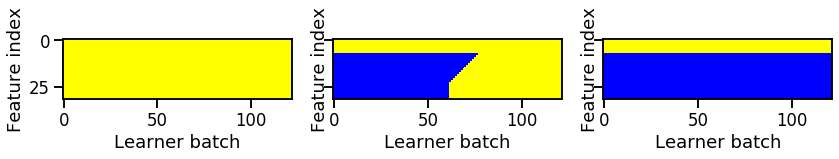

In [11]:
fig_feat_activity, ax_feat_activity = plt.subplots(1,3, figsize = 
                                                   (3 * 4, 4), sharey = True)

for e, a in zip(exp_data_all,  ax_feat_activity):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
fig_feat_activity.tight_layout()


# Behaviour comparision

## count how many rewards

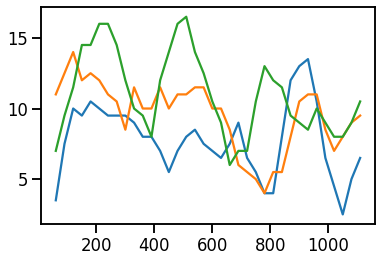

In [47]:
fps = 60

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']

    (reward_rate, window_time_stamps) = calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size=120,
                                                                window_step=30)

    plt.plot(window_time_stamps, reward_rate)

## Trial segments and trajectories

In [13]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239


def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = []
    
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [14]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)

range(17, 24)


In [15]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [16]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

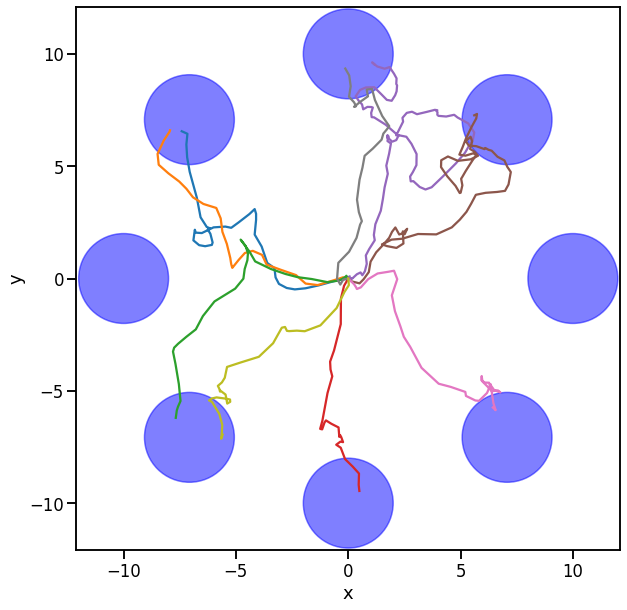

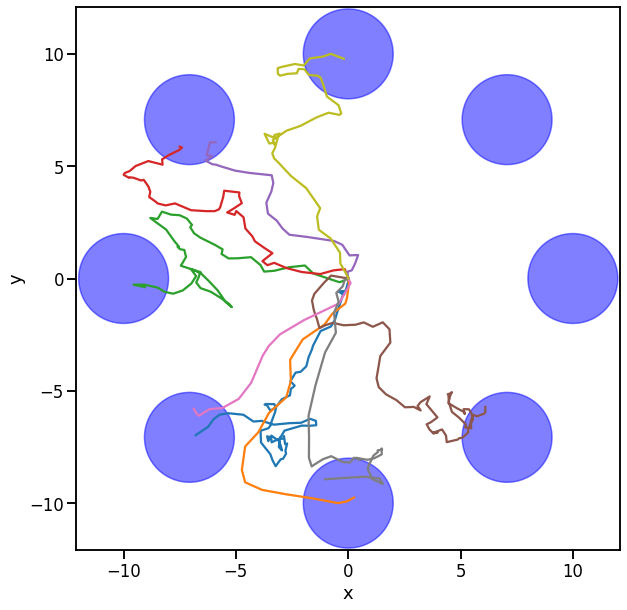

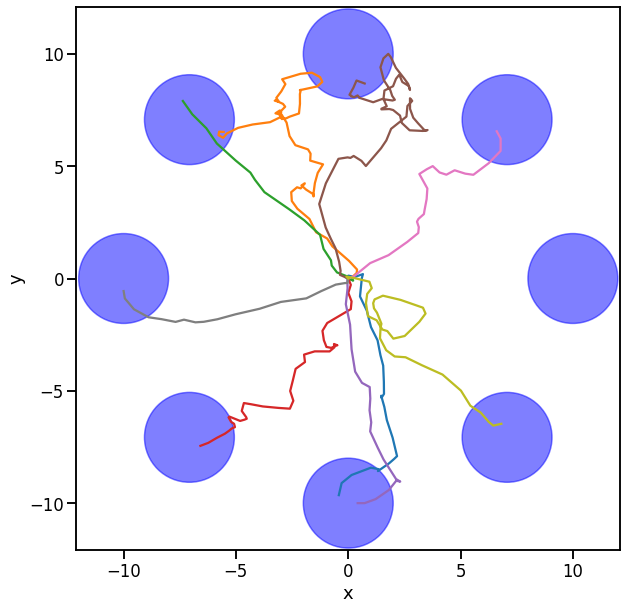

In [17]:
for c in cursor_trajectories_list:

    plot_cursor_trajectories(c[1:10], exp_data_all[0], exp_data_metadata_all[0])

In [18]:
events = exp_data_all[0]['events']
events['event'][10:21], events['timestamp'][10:21], events['time'][10:21]

events_time = (events['time'][10:21]) / 60
events_time

masked_array(data=[41.2, 41.416666666666664, 41.43333333333333, 51.45,
                   51.46666666666667, 61.483333333333334, 61.5, 65.3,
                   65.5, 65.51666666666667, 68.3],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value=999999)

In [19]:
def calc_running_event_rate(event_name, event_record, event_timestamps, 
                       window_size:float = 60., window_step = None):
    
    """
    this function calculates running averages of event rates for each window with window_size stepped over window_step.
    
    Args:
        event_name(string or int): event name e.g. b'REWARD' or 48
        event_record(list, tuple, np.ndarray): event record with length of number of events
        event_timstampts((list, tuple, np.ndarray)): timestamps in seconds with length of number of events
        window_size(float): the running window size, defaults to 60 s or 1 minute
        window_step(float): the step between betweens, if none, calculate the event rate with NON-OVERLAPPING windows
        
    Returns
        a tuple of: 
        runnning_event_rate(np.ndarray): an array with running event rates
        window_timestamps(np.ndarray): timestamps at the middle of windows
        
    
    
    """
    
    #convert event_record and event_timestamps if not already are
    
    if event_record is not np.ndarray: event_record = np.array(event_record)
    if event_timestamps is not np.ndarray: event_timestamps = np.array(event_timestamps)
    
    
    # check if event_record and event_timestamps have the same length
    assert event_record.ndim == event_timestamps.ndim == 1
    assert event_record.size == event_timestamps.size
    
    if window_step is None: window_step = window_size
        
    event_record_index = np.argwhere(event_record == event_name)
    filtered_event_timestamps = event_timestamps[event_record_index]
    
    # get ready for the search
    start_timestamp = event_timestamps[0]
    last_timestamp = event_timestamps[-1]
    stop_timestamp = start_timestamp + window_size
    
    event_rate = list()
    start_timestamp_list = list()
    while stop_timestamp < last_timestamp:
        
        event_per_window = np.count_nonzero(np.logical_and(filtered_event_timestamps >= start_timestamp,
                                                          filtered_event_timestamps < stop_timestamp)  )
        
        event_rate.append(event_per_window)
        start_timestamp_list.append(start_timestamp)
        
        #shift the window
        start_timestamp = start_timestamp + window_step
        stop_timestamp = stop_timestamp + window_step
        
    
    
    #normalize to the window size
    event_rate = np.array(event_rate)
    event_rate = event_rate / window_size * 60
    
    #calculate the window timstamps
    window_time_stamps = np.array(start_timestamp_list) + 0.5 * window_size
    
    
    return (event_rate, window_time_stamps)
        
        
    

def test_calc_running_event():
    event_record = np.array([b'CURSOR_ENTER_TARGET', # happens at 1.1s
                             b'REWARD',              # 31s
                             b'TARGET_ON',           # 32s
                             b'TIMEOUT_PENALTY',     # 33
                             b'TARGET_ON',           # 34
                             b'TIMEOUT_PENALTY',     # 35
                             b'TARGET_ON',           # 36
                             b'CURSOR_ENTER_TARGET', # 61
                             b'REWARD',              # 90
                             b'TARGET_ON',           # 92
                             b'CURSOR_ENTER_TARGET'])# 130
    
    timestamps = np.array([1.1, 31, 32, 33, 34, 35, 36, 61, 90, 92, 130])
    
    # for the 130s, there are two 60s windows, 
    # each window has 1 reward event
    expected_reward_rate = np.array([1,1])
    
    # the windows are centered around
    expected_window_stamps = np.array([31.1, 91.1])
    
    (calculated_reward_rate, window_timestamps) = calc_running_event_rate(b'REWARD', event_record, timestamps, window_size = 60)
    
    np.testing.assert_array_equal(expected_reward_rate, calculated_reward_rate)
    np.testing.assert_array_equal(expected_window_stamps, window_timestamps)
    
    event_record = np.array([0, # happens at 1.1s
                             1,              # 31s
                             0,              # 32s
                             0,              # 33
                             0,              # 34
                             0,              # 35
                             0,              # 36
                             0,              # 61
                             1,              # 90
                             0,              # 92
                             0])             # 130
    
    timestamps = np.array([1.1, 31, 32, 33, 34, 35, 36, 61, 90, 92, 130])
    
    (calculated_reward_rate, window_timestamps) = calc_running_event_rate(1, event_record, timestamps, window_size = 60)
    
    np.testing.assert_array_equal(expected_reward_rate, calculated_reward_rate)
    np.testing.assert_array_equal(expected_window_stamps, window_timestamps)
    
    
    
    
    
    
    

test_calc_running_event()

# Post data analysis

# Behaviour  analyses

## Trajectory analysis

In [20]:
def calculate_traj_length(trajectories):
    """
    given a list of trajectories, calculate each trajectory's length
    
    args:
        trajectories[np.ndarray]: number of data points by number of dims
    """
    traj_length = np.empty((len(trajectories)))
    
    for i,t in enumerate(trajectories):
        delta = np.diff(t, axis = 0)
        
        
        delta_length = delta**2
        
        
        delta_sum = np.sum(delta_length, axis = 1) ** (1/2)
        
        delta_sum = np.sum(delta_sum)
        
        traj_length[i] = delta_sum
        
    return traj_length
        
        

def test_calculate_traj_length():
    
    
    #test a line segment length
    cursor_trajectory = np.arange(0,1, 0.1).reshape(-1,1)
    expected_trajectory_length = np.array([0.9])
    calculated_trajectory_length = calculate_traj_length([cursor_trajectory])
    
    np.testing.assert_array_equal(expected_trajectory_length, calculated_trajectory_length)
    
    
test_calculate_traj_length()    

Text(0.5, 0, 'Trial #')

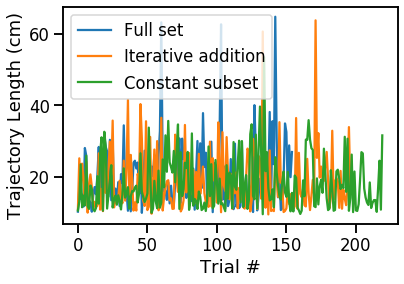

In [21]:

 
cursor_length = [calculate_traj_length(t) for t in cursor_trajectories_list]

for c in cursor_length:
    plt.plot(c)
    
plt.legend(['Full set','Iterative addition', 'Constant subset'])
plt.ylabel('Trajectory Length (cm)')

plt.xlabel('Trial #')

## Variance analysis

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [22]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

In [23]:
clda_log = exp_data_all[0]['bmi3d_clda']


In [24]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

In [25]:
print(clda_log['kf_C'][-1])

[[ 0.       0.       0.       4.26032  0.       0.81607 38.07901]
 [ 0.       0.       0.      -1.42987  0.       3.54996 32.5844 ]
 [ 0.       0.       0.      -2.29516  0.       0.01914 40.2703 ]
 [ 0.       0.       0.       0.18878  0.      -4.12395 33.80153]
 [ 0.       0.       0.       0.47114  0.       1.52712 36.62777]
 [ 0.       0.       0.       0.88668  0.       1.78052 37.85254]
 [ 0.       0.       0.      -3.46088  0.      -0.6096  34.7819 ]
 [ 0.       0.       0.       1.82366  0.      -6.67065 35.18144]
 [ 0.       0.       0.       3.58938  0.      -1.77595 47.01698]
 [ 0.       0.       0.      -0.01224  0.       2.42992 40.68959]
 [ 0.       0.       0.      -0.58144  0.      -0.06981 42.95014]
 [ 0.       0.       0.      -1.81351  0.      -1.7036  46.16574]
 [ 0.       0.       0.       2.73793  0.      -1.89386 53.04668]
 [ 0.       0.       0.       1.06869  0.      -1.32887 40.41202]
 [ 0.       0.       0.       0.24987  0.      -2.06982 47.35944]
 [ 0.     

## decoder

In [26]:
exp_data_all[0]['feature_selection'].keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'n_starting_feats', 'n_states', 'noise_mode', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

(121, 32, 7)


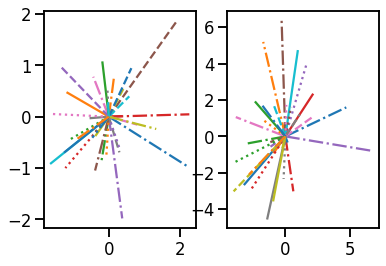

In [27]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[1]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

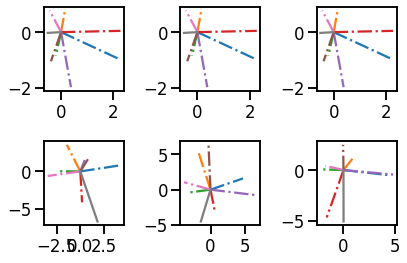

In [28]:
from afs_plotting import plot_prefered_directions

def plot_all_initial_C_mat(exp_data_all, selected_neuron = 'all',debug = True):
    
    """
    just compare initial C mat with the last C_mat
    """
    
    N_EXP = len(exp_data_all)
    
    fig, ax = plt.subplots(2, N_EXP)
    
    for i in range(N_EXP):
        C_mat = exp_data_all[i]['feature_selection']['C_mat']
        plot_prefered_directions(C_mat[0][no_noise_neuron_ind,:], ax = ax[0,i])
        plot_prefered_directions(C_mat[-1][no_noise_neuron_ind,:], ax = ax[1,i])
        

plot_all_initial_C_mat(exp_data_all)
plt.tight_layout()

## Decoder compared to the encoder



In [29]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

(121, 32, 7)
(121, 32)
(121, 32, 7)
(121, 32)
(121, 32, 7)
(121, 32)


Text(0.5, 1.0, 'C matrix')

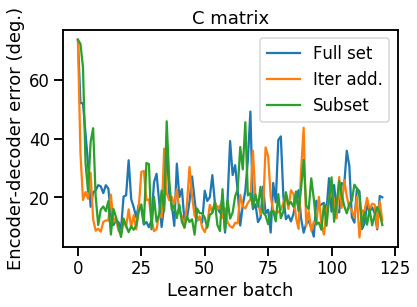

In [30]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix



for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['C_mat']
    
    print(dec_directions.shape)

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    print(angles_hist.shape)
    
#     if i == 0:
#         active_angles = np.mean(angles_hist[:,noise_neuron_list], axis = 1)
#         plt.plot(active_angles)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    
    plt.plot(active_angles)

plt.xlabel('Learner batch')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])
plt.title('C matrix')

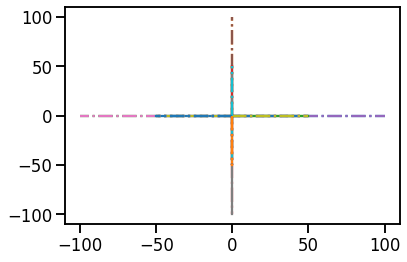

In [31]:
plot_prefered_directions(enc_directions)

## looking at K matrix

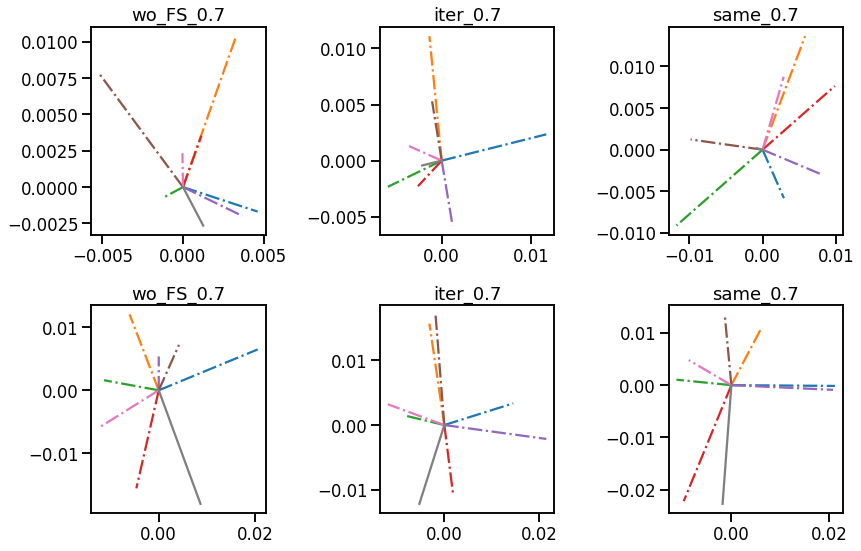

In [32]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))



#compare the K matrix before the exp
for i,e in enumerate(exp_conds):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[1].T

    plot_prefered_directions(K[no_noise_neuron_ind,:], ax  = axes_k_matrix[0, i])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i,e in enumerate(exp_conds):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K[no_noise_neuron_ind,: ], ax  = axes_k_matrix[1, i])
    axes_k_matrix[1,i].set_title(exp_conds[i])
    
    
figure_k_matrix.tight_layout()

In [33]:
feature_selection_data.keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'init_feat_set', 'n_starting_feats', 'n_states', 'noise_mode', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

(121, 7, 32)
(121, 7, 32)


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(121, 7, 32)


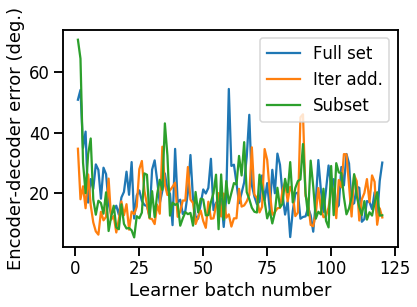

In [34]:
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[0]


for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['K_mat']
    print(dec_directions.shape)
    dec_directions = np.moveaxis(dec_directions, 2,1)

    
    

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    
    plt.plot(active_angles)

plt.xlabel('Learner batch number')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

In [35]:
np.printoptions(precision = 5)


feature_selection_data = exp_data_all[0]['feature_selection']
enc_directions = feature_selection_data['sim_C']
dec_directions = feature_selection_data['K_mat']

print(dec_directions[1].T)

[[ 0.00146  0.      -0.00061  0.00464  0.      -0.00169  0.     ]
 [ 0.00093  0.       0.00348  0.0033   0.       0.01038  0.     ]
 [-0.00038  0.      -0.00024 -0.00124  0.      -0.00074  0.     ]
 [ 0.00032  0.       0.00118  0.00114  0.       0.00353  0.     ]
 [ 0.00116  0.      -0.0007   0.00368  0.      -0.00198  0.     ]
 [-0.00169  0.       0.00269 -0.0052   0.       0.0078   0.     ]
 [-0.00003  0.       0.00079 -0.00003  0.       0.00233  0.     ]
 [ 0.00041  0.      -0.00091  0.00125  0.      -0.00265  0.     ]
 [ 0.00075  0.       0.00112  0.0025   0.       0.00337  0.     ]
 [-0.00264  0.       0.00112 -0.00839  0.       0.00308  0.     ]
 [ 0.00072  0.       0.00042  0.00236  0.       0.00131  0.     ]
 [-0.00052  0.       0.00057 -0.00161  0.       0.00165  0.     ]
 [-0.00011  0.      -0.00027 -0.00037  0.      -0.0008   0.     ]
 [ 0.0022   0.       0.00129  0.00721  0.       0.004    0.     ]
 [-0.0024   0.       0.00106 -0.00764  0.       0.00294  0.     ]
 [ 0.0018 

## Q mat

In [36]:
feature_selection_data.keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'n_starting_feats', 'n_states', 'noise_mode', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

(0, 10)

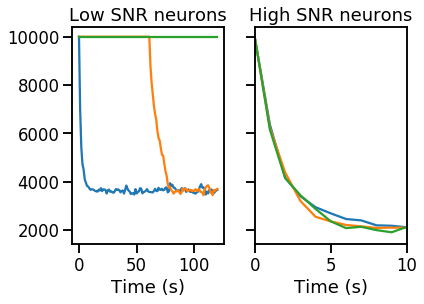

In [37]:
fig_Q, axes_Q = plt.subplots(1,2, sharey = True)

num_noises = 1

from afs_plotting import get_cmap
import matplotlib as mpl

cmap_q = get_cmap(num_noises)

cmap_q_1 = get_cmap(num_noises, mpl.cm.Oranges)

cmap_q_2 = get_cmap(num_noises, mpl.cm.Reds)



for i in range(num_noises):
    
    for j in range(3):


        Q_list = np.array(exp_data_all[j]["feature_selection"]['Q_diag'])



        Q_diag_no_noise = np.mean(Q_list[:, no_noise_neuron_ind], axis = 1)

        Q_diag_noise = np.mean(Q_list[:, noise_neuron_ind], axis = 1)



        axes_Q[0].plot(Q_diag_noise)

        axes_Q[1].plot(Q_diag_no_noise)

    

axes_Q[0].set_xlabel('Time (s)')

axes_Q[1].set_xlabel('Time (s)')



axes_Q[0].set_title('Low SNR neurons')

axes_Q[1].set_title('High SNR neurons')

axes_Q[1].set_xlim([0,10])

In [38]:
Q_diag_noise



array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
      

# Feature analysis

## examine used C mat

NameError: name 'C_mat_all' is not defined

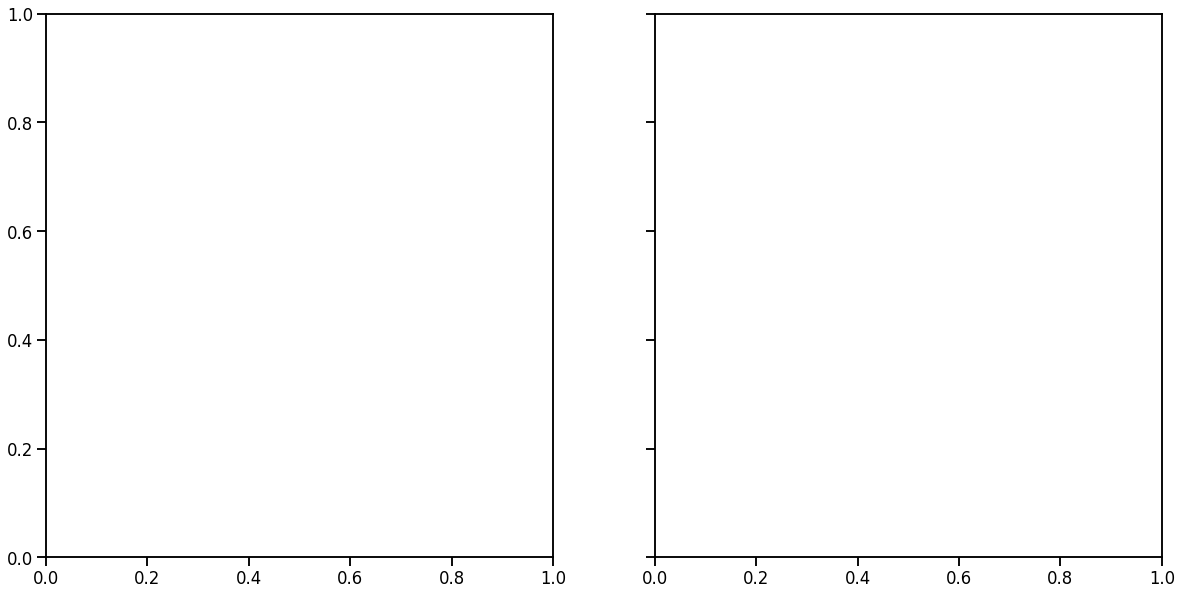

In [39]:
GLOBAL_FIGURE_VERTICAL_SIZE  =  10

fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list

for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = enc_directions)


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
    
#axes_compr_means.set_title('Means of the high SNR weight trajectory')